In [1]:
import torch
from torch import Tensor
from torch.distributions.transforms import Transform
import numpy as np
import zuko
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/home/valsdav/code/MEM/MEMFlow/myenv/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Neural spline flow (NSF) with 3 transformations
flow = zuko.flows.NSF(7, transforms=2, bins=8, hidden_features=[64] * 3, 
                      randperm=True)


In [3]:
flow

NSF(
  (transforms): ModuleList(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [5, 3, 2, 0, 1, 4, 6]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=64, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=64, out_features=161, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [4, 6, 0, 3, 2, 5, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=64, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=64, out_feat

(array([1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 7.000e+00, 9.000e+00,
        8.000e+00, 1.500e+01, 1.000e+01, 1.600e+01, 2.000e+01, 2.900e+01,
        2.100e+01, 4.000e+01, 3.900e+01, 5.400e+01, 6.300e+01, 7.900e+01,
        1.330e+02, 1.330e+02, 1.340e+02, 2.050e+02, 2.040e+02, 2.500e+02,
        3.030e+02, 3.730e+02, 4.170e+02, 4.610e+02, 5.280e+02, 5.870e+02,
        6.770e+02, 7.490e+02, 8.870e+02, 9.940e+02, 9.970e+02, 1.041e+03,
        1.112e+03, 1.192e+03, 1.347e+03, 1.344e+03, 1.602e+03, 1.611e+03,
        1.649e+03, 1.785e+03, 1.870e+03, 1.939e+03, 2.037e+03, 2.131e+03,
        2.163e+03, 2.302e+03, 2.333e+03, 2.537e+03, 2.456e+03, 2.466e+03,
        2.460e+03, 2.390e+03, 2.347e+03, 2.095e+03, 2.005e+03, 1.866e+03,
        1.578e+03, 1.383e+03, 1.196e+03, 1.155e+03, 9.790e+02, 8.350e+02,
        8.100e+02, 7.430e+02, 7.000e+02, 6.100e+02, 5.660e+02, 4.490e+02,
        4.110e+02, 3.280e+02, 2.920e+02, 2.800e+02, 2.260e+02, 2.070e+02,
        1.270e+02, 1.170e+02, 9.300e+0

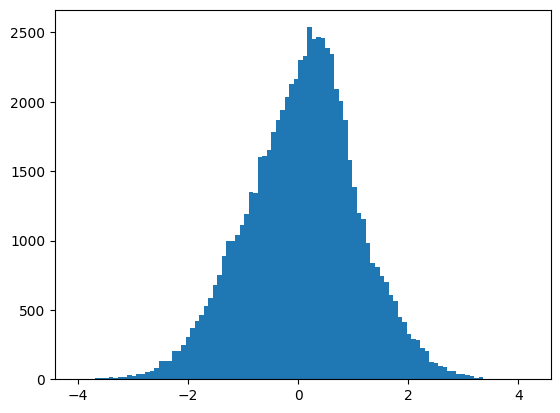

In [4]:
x1 = flow().sample((10000,))
plt.hist(x1.detach().numpy().flatten(), bins=100)

In [3]:
from zuko.transforms import (
    SoftclipTransform, ComposedTransform, 
    InverseTanhTransform, InverseSoftclipTransform,
    MonotonicAffineTransform)
from zuko.distributions import BoxUniform
from torch.distributions.transforms import TanhTransform, AffineTransform
from zuko.flows import TransformModule, SimpleAffineTransform

In [15]:
class IntervalToRealTransform(TransformModule):
    """
    Transform from Interval to R through an Affine and InverseSoftclip Transform
    """
    def __init__(self, xmin: Tensor, xmax: Tensor):
        super().__init__()
        self.xmin = xmin
        self.xmax = xmax
        self.scale = (2/(self.xmax -self.xmin))
        self.shift =  1 -self.scale*self.xmax
        
    def extra_repr(self) -> str:
        return f'[{self.xmin}, {self.xmax}] -> [-1,1] -> softclip -> R'
        
    def forward(self, y: Tensor = None) -> Transform:
        return ComposedTransform(
            AffineTransform(scale=self.scale, loc=self.shift),
            InverseSoftclipTransform(bound=1))

In [21]:
features = 7
flow2 = zuko.flows.NSF(features, transforms=4, bins=8, hidden_features=[32] * 2, 
                      randperm=True,
                      passes=2)

flow2.transforms.insert(0, IntervalToRealTransform(0*torch.ones(features),1*torch.ones(features)))

In [22]:
features = 7
flow3 = zuko.flows.NSF(features, transforms=4, bins=8, hidden_features=[32] * 2, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound":1},
                      passes=2)

flow3.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))

In [45]:
%%timeit
x2 = flow2().sample((10000,))

108 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%%timeit
y = flow2().log_prob(x2)

66.2 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 0, 'x2')

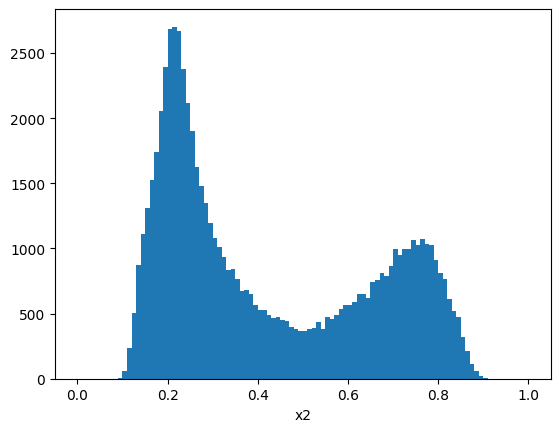

In [24]:
x2 = flow2().sample((10000,))
plt.hist(x2.flatten(), bins=100, range=(0,1))
plt.xlabel("x2")

Text(0.5, 0, 'x2')

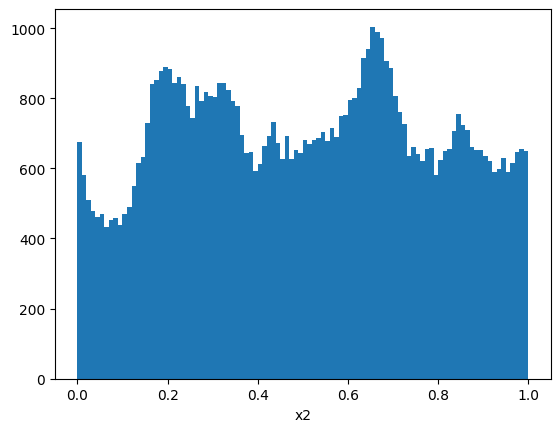

In [25]:
x3 = flow3().sample((10000,))
plt.hist(x3.flatten(), bins=100, range=(0,1))
plt.xlabel("x2")

(array([   3.,   13.,   19.,   65.,   89.,  120.,  156.,  150.,  202.,
         281.,  338.,  478.,  560.,  700.,  839.,  949., 1005., 1074.,
        1071., 1131., 1129., 1150., 1271., 1190., 1250., 1274., 1278.,
        1172., 1155., 1155., 1104., 1080., 1053., 1025.,  942.,  945.,
         882.,  855.,  813.,  832.,  793.,  729.,  708.,  773.,  765.,
         771.,  829.,  840.,  811.,  843.,  826.,  922.,  906.,  922.,
        1021., 1019., 1064., 1137., 1142., 1167., 1226., 1278., 1316.,
        1266., 1283., 1240., 1195., 1122., 1147.,  960.,  946.,  763.,
         694.,  644.,  566.,  450.,  409.,  347.,  318.,  367.,  322.,
         324.,  305.,  281.,  280.,  249.,  240.,  220.,  214.,  248.,
         213.,  180.,  168.,  149.,  113.,   79.,   50.,   30.,    9.,
           3.]),
 array([-1.0586797 , -1.03693485, -1.01519001, -0.99344522, -0.97170043,
        -0.94995558, -0.92821074, -0.90646595, -0.8847211 , -0.86297625,
        -0.84123147, -0.81948662, -0.79774183, -0.775996

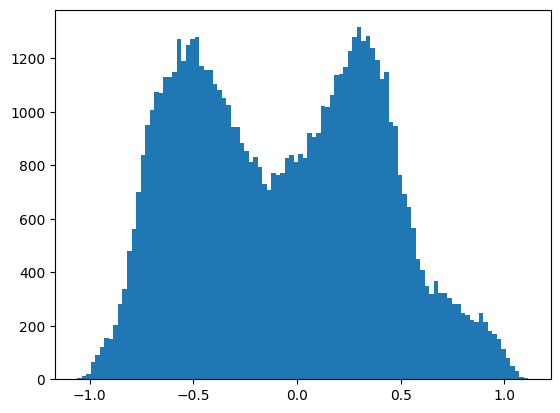

In [38]:
x = flow().sample((10000,))
plt.hist(x.detach().numpy().flatten(), bins=100)
#plt.yscale("log")

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
count_parameters(flow)

96485

In [9]:
x= torch.randn(10000,7)

In [29]:
%%timeit
# Evaluate log p(x | y)
log_p = flow().log_prob(x)

95.8 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
# Sample 64 points x ~ p(x | y)
x = flow().sample((10000,))

542 ms ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
x

tensor([[  3.3248,  -0.9988,   1.0427,  ...,  -0.1234,   0.9243,  -0.9559],
        [ -0.8994,  -0.8684,  -0.0907,  ...,  -4.1476,   0.6668,  -1.0164],
        [ -1.9476,  -0.2344,  -0.9650,  ...,   0.1011,   2.5343,  -0.7970],
        ...,
        [  0.8191,  -3.5831,  -3.3464,  ...,   1.1201,   0.4716,  -3.2971],
        [  1.4133,  -0.5995,  -1.5326,  ...,   3.0725, -14.7942,   3.2601],
        [ -0.7108,  -0.2819,  -0.6786,  ...,   1.3522,  -4.1374,   1.5667]])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

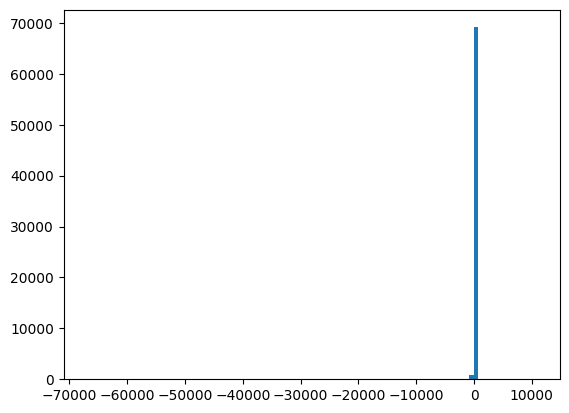

# t = zuko.flows.MaskedAutoregressiveTransform(3)

In [58]:
t

MaskedAutoregressiveTransform(
  (base): MonotonicAffineTransform()
  (order): [0, 1, 2]
  (hyper): MaskedMLP(
    (0): MaskedLinear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): MaskedLinear(in_features=64, out_features=6, bias=True)
  )
)

In [18]:
x = torch.randn(3)

In [23]:
x

tensor([0.5497, 0.2524, 0.1363])

In [24]:
z = t()(x)
z

tensor([0.6078, 0.2602, 0.3210], grad_fn=<AddBackward0>)

In [25]:
t().inv(z)

tensor([0.5497, 0.2524, 0.1363], grad_fn=<DivBackward0>)

In [27]:
a = t()

In [32]:
a.log_abs_det_jacobian(x, z)


tensor(-0.0481, grad_fn=<SumBackward1>)

In [120]:
t = zuko.flows.NSF(3, 4)

In [128]:
a = t.transforms[0]

In [119]:
t.univariate

zuko.transforms.MonotonicAffineTransform

In [113]:
class Test:
    def __init__(self, a=1):
        print("calling constructor")
        
    def __call__(self, b):
        print("function: ", b)

In [115]:
a= Test

In [117]:
a(2)

calling constructor


In [134]:
from torch.nn import functional as F

In [142]:
torch.cumsum(F.pad(torch.tensor([0.2,0.3,0.8]), (1, 0), value=-1), dim=-1)

tensor([-1.0000, -0.8000, -0.5000,  0.3000])

# Nflows

In [59]:
from nflows import transforms, flows, distributions
from torch.distributions.transforms import TanhTransform

In [79]:
# Define an invertible transformation.
nfeat = 7
transform = transforms.CompositeTransform([
    #TanhTransform(),
    transforms.RandomPermutation(features=nfeat),
    transforms.MaskedAffineAutoregressiveTransform(features=nfeat, hidden_features=36),
    transforms.RandomPermutation(features=nfeat),
    transforms.MaskedAffineAutoregressiveTransform(features=nfeat, hidden_features=36),
    transforms.RandomPermutation(features=nfeat),
    transforms.MaskedAffineAutoregressiveTransform(features=nfeat, hidden_features=36)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[nfeat])


# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)

In [71]:
flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=7, out_features=36, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=36, out_features=36, bias=True)
                (1): MaskedLinear(in_features=36, out_features=36, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=36, out_features=36, bias=True)
                (1): MaskedLinear(in_features=36, out_features=36, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_

In [48]:
x = torch.randn(10000,7)

In [49]:
%%timeit
prob = flow.log_prob(x)

12.8 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 1.400e+01, 9.000e+00, 1.400e+01,
        1.500e+01, 3.200e+01, 2.000e+01, 3.600e+01, 4.900e+01, 5.800e+01,
        8.300e+01, 1.040e+02, 1.510e+02, 1.710e+02, 2.880e+02, 3.090e+02,
        3.750e+02, 5.050e+02, 5.980e+02, 7.460e+02, 8.400e+02, 1.065e+03,
        1.326e+03, 1.463e+03, 1.680e+03, 2.017e+03, 2.194e+03, 2.455e+03,
        2.735e+03, 2.931e+03, 3.022e+03, 3.064e+03, 3.257e+03, 3.215e+03,
        3.243e+03, 3.137e+03, 3.029e+03, 2.933e+03, 2.730e+03, 2.572e+03,
        2.357e+03, 2.133e+03, 1.965e+03, 1.712e+03, 1.573e+03, 1.369e+03,
        1.125e+03, 9.470e+02, 8.070e+02, 6.320e+02, 5.830e+02, 4.310e+02,
        4.010e+02, 3.070e+02, 2.760e+02, 2.100e+02, 1.630e+02, 1.120e+02,
        9.300e+01, 7.600e+01, 5.700e+01, 4.300e+01, 2.800e+01, 2.300e+01,
        1.600e+01, 1.200e+01, 9.000e+0

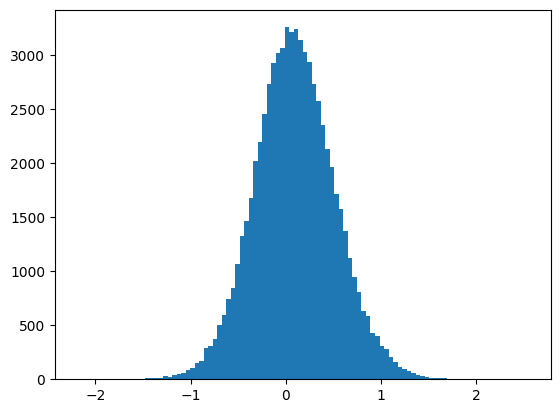

In [50]:
plt.hist(flow.transform_to_noise(x).detach().numpy().flatten(), bins=100)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   1.,   3.,   2.,   4.,   2.,   2.,
          3.,   3.,   7.,   7.,   9.,   7.,   8.,  12.,  15.,  15.,  18.,
         21.,  26.,  27.,  35.,  42.,  33.,  49.,  52.,  51.,  68.,  65.,
         76.,  82.,  87.,  90., 141., 141., 159., 163., 194., 192., 219.,
        214., 273., 286., 309., 294., 355., 330., 364., 390., 373., 377.,
        412., 368., 351., 349., 362., 354., 316., 303., 291., 250., 202.,
        179., 147., 106.,  94.,  70.,  68.,  30.,  19.,   9.,   6.,   6.,
          5.]),
 array([-17.53205299, -17.48608208, -17.44010925, -17.39413834,
        -17.34816551, -17.3021946 , -17.25622368, -17.21025085,
        -17.16427994, -17.11830711, -17.0723362 , -17.02636528,
        -16.98039246, -16.93442154, -16.88844872, -16.8424778 ,
        -16.79650688, -16.75053406, -16.70456314, -16.65859032

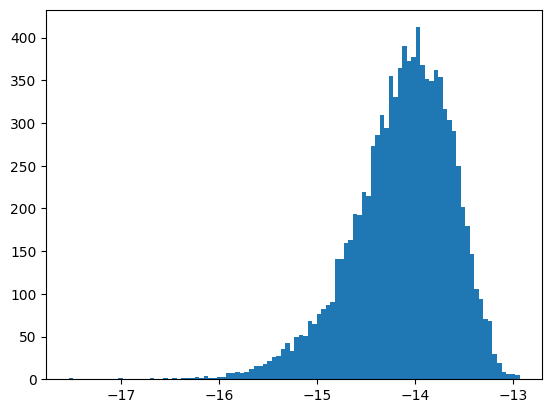

In [51]:
plt.hist(flow.log_prob(x).detach().numpy(), bins=100)

In [52]:
%%timeit
samples = flow.sample(10000)

88.4 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
samples = flow.sample(10000)

In [72]:
samples

tensor([[ 3.1385,  2.1119,  3.9893,  ..., -2.3763, -4.0163,  2.2688],
        [ 1.6276, -2.4258,  1.0735,  ...,  4.2858, -4.6150,  1.5192],
        [ 2.6981, -0.5572,  2.1691,  ...,  2.2403, -4.3343, -0.0933],
        ...,
        [-1.3603,  0.9711,  2.9449,  ..., -4.0825, -2.2342, -1.8655],
        [-1.4279, -4.2873,  0.7951,  ...,  0.8065,  4.0543, -0.4443],
        [-1.2333,  0.7318, -0.2392,  ..., -1.8454, -3.7835,  0.1593]],
       grad_fn=<IndexSelectBackward0>)

(array([  35.,   34.,   44.,   57.,   51.,   44.,   67.,   71.,   87.,
          88.,   91.,  110.,  124.,  132.,  149.,  164.,  156.,  180.,
         220.,  238.,  245.,  292.,  307.,  376.,  406.,  471.,  479.,
         549.,  588.,  694.,  719.,  789.,  891.,  936., 1060., 1195.,
        1245., 1340., 1452., 1486., 1644., 1640., 1705., 1772., 1808.,
        1924., 1890., 1817., 1879., 1971., 1892., 1785., 1742., 1743.,
        1628., 1581., 1529., 1416., 1327., 1262., 1205., 1046., 1063.,
         934.,  881.,  829.,  820.,  739.,  698.,  596.,  604.,  594.,
         509.,  495.,  437.,  425.,  375.,  355.,  334.,  279.,  311.,
         254.,  264.,  247.,  204.,  196.,  208.,  166.,  151.,  140.,
         124.,  109.,  119.,  100.,   96.,   92.,   92.,   88.,   78.,
          63.]),
 array([-10.        ,  -9.80000019,  -9.60000038,  -9.39999962,
         -9.19999981,  -9.        ,  -8.80000019,  -8.60000038,
         -8.39999962,  -8.19999981,  -8.        ,  -7.80000019,
         -

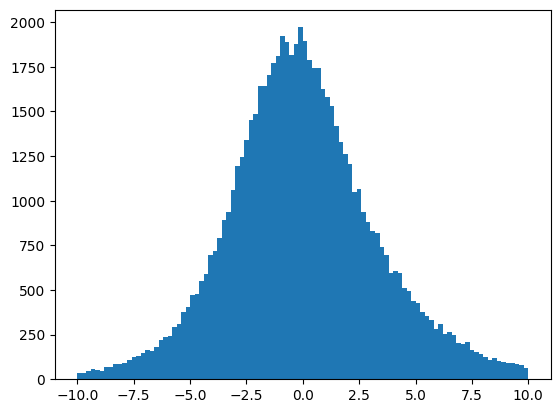

In [84]:
plt.hist(samples.detach().numpy().flatten(), bins=100, range=(-10,10))

(array([15820.,  2559.,  1630.,  1238.,   994.,   890.,   772.,   700.,
          617.,   548.,   467.,   487.,   417.,   421.,   388.,   339.,
          342.,   331.,   311.,   291.,   285.,   294.,   274.,   249.,
          276.,   276.,   266.,   231.,   234.,   226.,   237.,   214.,
          184.,   214.,   194.,   202.,   187.,   194.,   201.,   228.,
          226.,   202.,   175.,   193.,   220.,   198.,   170.,   190.,
          190.,   191.,   187.,   189.,   185.,   194.,   181.,   195.,
          198.,   171.,   187.,   177.,   200.,   175.,   203.,   191.,
          197.,   211.,   188.,   190.,   179.,   189.,   209.,   202.,
          238.,   223.,   205.,   235.,   267.,   217.,   257.,   253.,
          282.,   263.,   302.,   354.,   337.,   338.,   328.,   406.,
          397.,   460.,   445.,   495.,   592.,   654.,   657.,   836.,
         1024.,  1330.,  2083., 16141.]),
 array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
        0.05      , 0.06  

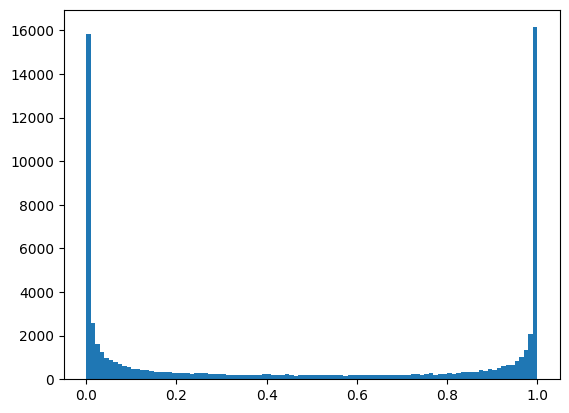

In [109]:
y = ((torch.tanh(samples)/2)+0.5)
plt.hist(y.detach().numpy().flatten(), bins=100)

In [102]:
x = np.arange(-30, 30)

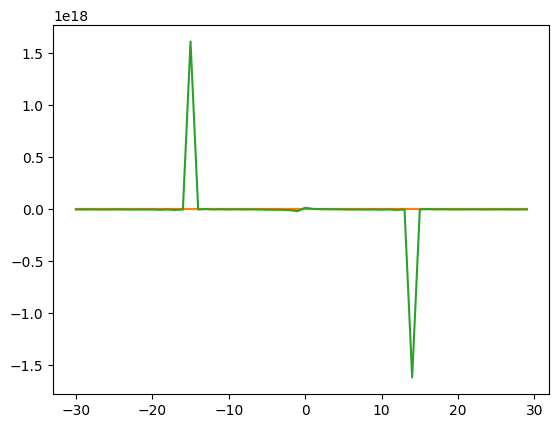

In [103]:
plt.plot(x, 1/(1+np.exp(x)))
plt.plot(x, (np.tanh(x)/2)+0.5)
plt.plot(x, np.tan((x+0.5)*np.pi))

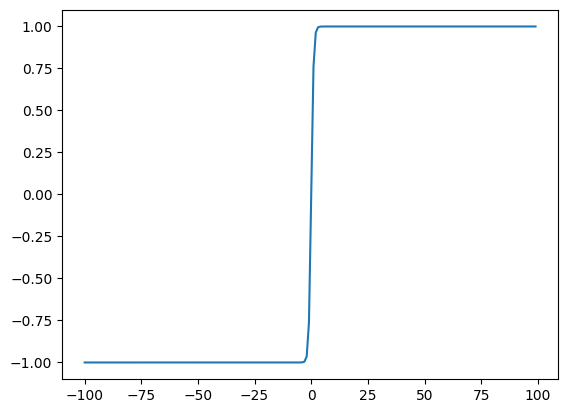

In [ ]:
 x / (1 + abs(x / self.bound))